In [5]:
import os
import re
import pandas as pd
import joblib
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

from sklearn.preprocessing import MinMaxScaler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import logging
from transformers import DistilBertTokenizer, TFDistilBertModel

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


'''nltk.download('stopwords')
nltk.download('punkt')
'''
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')






In [6]:
def preprocess_text(data):
    if pd.isna(data):
        return ""
    words = word_tokenize(data.lower())
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
    return " ".join(filtered_words)


def compute_text_length_features(df, text_column):
    df['char_count'] = df[text_column].apply(len)
    df['word_count'] = df[text_column].apply(lambda x: len(x.split()))
    df['sentence_count'] = df[text_column].apply(lambda x: len([s for s in re.split(r'[.!?]', x) if s.strip() != '']))
    df['avg_word_length'] = df['char_count'] / (df['word_count'] + 1) # avoid division by zero
    return df

def compute_sentiment_features(df, text_column):
    sia = SentimentIntensityAnalyzer()
    sentiments = df[text_column].apply(lambda  x: sia.polarity_scores(x))
    df['sentiment_neg'] = sentiments.apply(lambda x: x['neg'])
    df['sentiment_neu'] = sentiments.apply(lambda x: x['neu'])
    df['sentiment_pos'] = sentiments.apply(lambda x: x['pos'])
    df['sentiment_compound'] = sentiments.apply(lambda x: x['compound'])
    return df

def compute_lexical_diversity(df, text_column):
    df['lexical_diversity'] = df[text_column].apply(lambda x: len(set(x.split())) / (len(x.split()) + 1))
    return df

def compute_subjectivity(df, text_column):
    df['subjectivity'] = df[text_column].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    return df

'''def extract_bert_features(text_data, batch_size=32):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    features = []
    for i in range(0, len(text_data), batch_size):
        inputs = tokenizer(text_data[i:i + batch_size].tolist(), return_tensors='tf', padding=True, truncation=True, max_length=512)
        outputs = model(inputs)
        batch_features = np.mean(outputs.last_hidden_state.numpy(), axis=1)
        features.append(batch_features)
    
    return np.vstack(features)'''


"def extract_bert_features(text_data, batch_size=32):\n    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')\n    model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')\n\n    features = []\n    for i in range(0, len(text_data), batch_size):\n        inputs = tokenizer(text_data[i:i + batch_size].tolist(), return_tensors='tf', padding=True, truncation=True, max_length=512)\n        outputs = model(inputs)\n        batch_features = np.mean(outputs.last_hidden_state.numpy(), axis=1)\n        features.append(batch_features)\n    \n    return np.vstack(features)"

In [7]:
# Load trained model and preprocessing tools
model = joblib.load('xgb_model.pkl')
scaler = joblib.load('scaler.pkl')

# Load the first 10,000 rows of the raw Reddit dataset
raw_data_path = '../Raw-data-Reddit/reddit_opinion_ru_ua.csv'
reddit_df = pd.read_csv(raw_data_path, nrows=10000)

precomputed_features_path = './DistilBERT_Features/bert_features10000.h5'
with h5py.File(precomputed_features_path, 'r') as h5f:
    distilbert_features = h5f['features'][:10000]




# Preprocess the text data
reddit_df['processed_content'] = reddit_df['self_text'].apply(preprocess_text)

# Compute additional features as done in the training phase
reddit_df = compute_text_length_features(reddit_df, 'processed_content')
reddit_df = compute_sentiment_features(reddit_df, 'processed_content')
reddit_df = compute_lexical_diversity(reddit_df, 'processed_content')
reddit_df = compute_subjectivity(reddit_df, 'processed_content')

# Extract relevant numerical features
numerical_features = ['char_count', 'word_count', 'sentence_count', 'avg_word_length',
                      'sentiment_neg', 'sentiment_neu', 'sentiment_pos', 'sentiment_compound',
                      'lexical_diversity', 'subjectivity']

#Fill NaN values for numerical features
reddit_df[numerical_features] = reddit_df[numerical_features].fillna(0)

#Normalise numerical features 
reddit_df[numerical_features] = scaler.transform(reddit_df[numerical_features])

#Extract DistilBERT features for text 
text_data = reddit_df['processed_content']
#distilbert_features = extract_bert_features(text_data)

#Combine DistilBERT features with numerical features 
combined_features = np.hstack((distilbert_features, reddit_df[numerical_features].values))

#Make predictions using the trained model
predictions = model.predict(combined_features)

#Add predictions to the original dataset
reddit_df['predictions'] = predictions

print(reddit_df[['processed_content', 'predictions']])

output_file = './Results_Application/reddit_predictions_first_10000.csv'

reddit_df[['processed_content', 'predictions']].to_csv(output_file, index=False)

logging.info(f"Results saved to {output_file}")


2024-08-31 13:29:36,163 - INFO - Results saved to ./Results_Application/reddit_predictions_first_10000.csv


                                      processed_content  predictions
0     ukraine apparently according russia making 300...            1
1                                                                  1
2     us congress may begin collecting signatures fr...            1
3     putin psychological profile intelligence servi...            1
4     tl dr ukraine employs mobile patriot units nea...            1
...                                                 ...          ...
9995  thing even russia alone beat napoleon europe m...            0
9996  see ukraine economy still full wartime mode 2 ...            0
9997  died shitty lada generously donated ruzzian pimps            0
9998  laying groundwork use syrsky scapegoat future ...            0
9999                                         hard drink            0

[10000 rows x 2 columns]


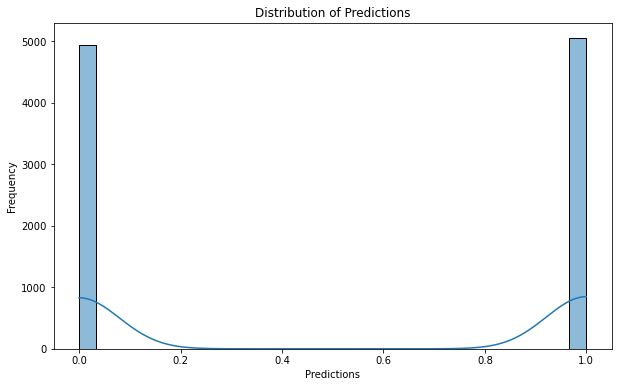

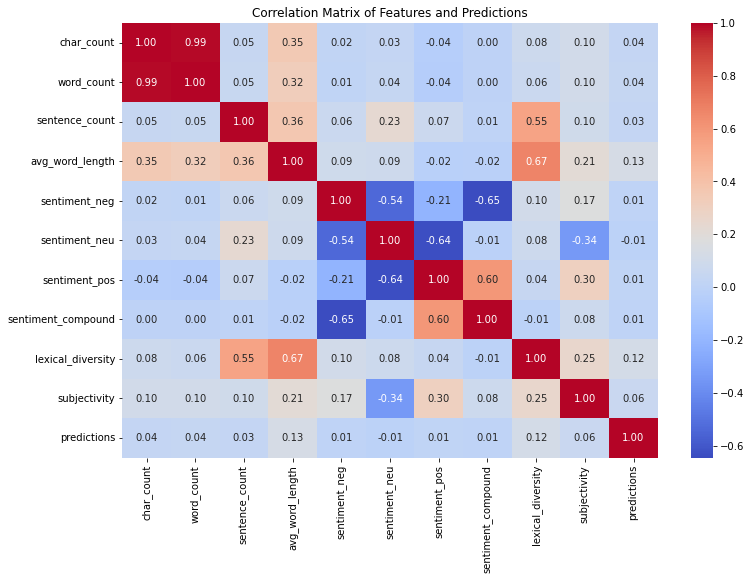

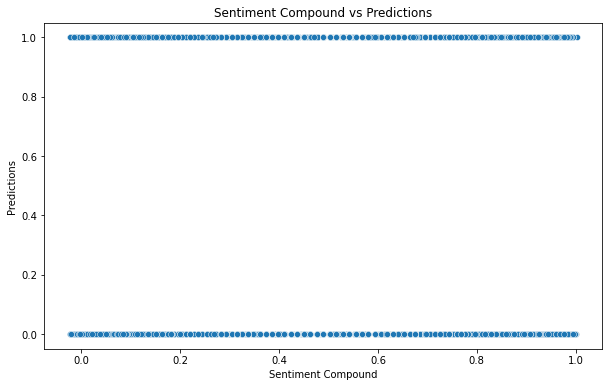

In [8]:
#PLOTTING
# 1. Distribution of Predictions
plt.figure(figsize=(10, 6))
sns.histplot(reddit_df['predictions'], bins=30, kde=True)
plt.title('Distribution of Predictions')
plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.show()

# 2. Correlation Heatmap between features and predictions
correlation_matrix = reddit_df[numerical_features + ['predictions']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features and Predictions')
plt.show()

# 3. Scatter Plot - Example between sentiment_compound and predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reddit_df['sentiment_compound'], y=reddit_df['predictions'])
plt.title('Sentiment Compound vs Predictions')
plt.xlabel('Sentiment Compound')
plt.ylabel('Predictions')
plt.show()